# GFN-ROM

This notebook trains the GFN-ROM model and evaluates the performance.

# Imports

In [1]:
import torch
from torch import nn
import numpy as np

from torchinfo import summary

import sys
sys.path.append("..")
from gfn_rom import pde, defaults, preprocessing, initialisation, gfn_rom, train, test, plotting

# Hyperparameter and Problem Setup

In [2]:
pname = 'stokes'

# training and test fidelities
train_fidelities = ['medium']
test_fidelities = ['large', 'medium', 'small', 'tiny']

# Naming convention for saving the model
save_name = ''.join(train_fidelities)

In [3]:
dev = initialisation.set_device()
initialisation.set_precision(defaults.precision)
params = torch.tensor(pde.params(pname)).to(dev)
np.random.seed(defaults.split_seed)
train_trajs, test_trajs = preprocessing.train_test_split(params, len(train_fidelities), defaults.rate)
meshes_train, sols_train, meshes_test, sols_test = preprocessing.load_and_process_datasets(train_fidelities, test_fidelities)
sols_train = [x.to(dev) for x in sols_train]
initialisation.set_seed(defaults.seed)
start_mesh = sorted(meshes_train, key=lambda x: x.shape[0])[0]
update_master = defaults.mode == 'adapt'

reconstruction error tensor(2.9014e-27)
reconstruction error tensor(9.3287e-27)
reconstruction error tensor(2.9014e-27)
reconstruction error tensor(9.7520e-28)
reconstruction error tensor(3.4523e-28)


# Model Initialisation

In [4]:
model = gfn_rom.GFN_ROM(start_mesh, defaults.N_basis_factor, defaults.latent_size, params.shape[1], defaults.act, defaults.ae_sizes, defaults.mapper_sizes).to(dev)
print(model.GFN.mesh_m.shape)

# We do all of the possible expansions apriori in the preadaptive case
# This is a preprocessing step so we don't do any speedup steps here
if defaults.mode=='preadapt':
    count = 0
    while count!=0:
        count = 0
        for mesh_n in meshes_train:
            n_exp, n_agg = model.GFN.reshape_weights(mesh_n, update_master=True)
            count += n_exp
    print(model.GFN.mesh_m.shape)

(2226, 2)


In [5]:
summary(model)

Layer (type:depth-idx)                   Param #
GFN_ROM                                  --
├─GFN_AE: 1-1                            46,756
├─Tanh: 1-2                              --
├─Sequential: 1-3                        --
├─Sequential: 1-4                        --
├─Sequential: 1-5                        --
│    └─Linear: 2-1                       400
│    └─Tanh: 2-2                         --
│    └─Linear: 2-3                       2,550
│    └─Tanh: 2-4                         --
│    └─Linear: 2-5                       2,550
│    └─Tanh: 2-6                         --
│    └─Linear: 2-7                       2,550
│    └─Tanh: 2-8                         --
│    └─Linear: 2-9                       510
Total params: 55,316
Trainable params: 55,316
Non-trainable params: 0

In [6]:
if not update_master:
    opt = torch.optim.Adam(model.parameters(), lr=defaults.lr, weight_decay=defaults.lambda_)
else:
    # Cannot update GFN parameters using Adam anymore since we use adaptive method
    # and weights can change shape at each iteration
    # Similarly, cannot use momentum
    opt = torch.optim.SGD(model.parameters(), lr=defaults.lr, weight_decay=defaults.lambda_)

# Training

Training network


100%|██████████████████████████████████| 5000/5000 [04:08<00:00, 20.14it/s, Loss(training)=0.0311, Loss(testing)=0.0855]


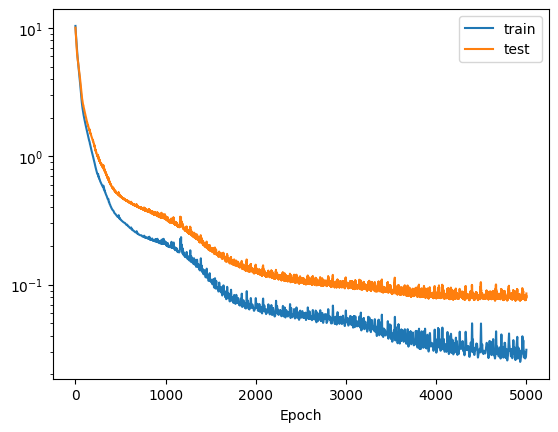

In [7]:
try:
    model.load_state_dict(torch.load("models/best_model"+save_name+".pt"))
    print("Loading saved network")
except FileNotFoundError:
    print("Training network")
    train_losses, test_losses = train.train(model, opt, meshes_train, sols_train, params, train_trajs, test_trajs, update_master, defaults.epochs, defaults.mapper_weight, save_name)
    model.load_state_dict(torch.load("models/best_model_"+save_name+".pt"))
    plotting.plot_losses(train_losses, test_losses, save_name)

# Testing

In [8]:
for i in range(len(test_fidelities)):
    
    print('-'*40)
    print(f'TEST MESH: {test_fidelities[i]}')
    
    scale, U = sols_test[i]
    U = U.to('cpu')
    mesh = meshes_test[i]

    model.eval()
    model.to('cpu')
    
    Z, Z_net, x_enc, x_map = test.evaluate_results(model, mesh, U, scale, params.to('cpu'))
    error = abs(Z - Z_net)
    error, rel_error = test.print_results(Z, Z_net, x_enc, x_map)

    np.savetxt('errors/relative_errors_train'+save_name+'_test'+test_fidelities[i]+'.txt', [max(rel_error), sum(rel_error)/len(rel_error), min(rel_error)])
    print()

----------------------------------------
TEST MESH: large

Maximum relative error for latent  =  0.5960338966523818
Mean relative error for latent =  0.24615912436581758
Minimum relative error for latent =  0.06649473116410583

Maximum absolute error for field  =  10.184074811994083
Mean absolute error for field  =  4.078792902609862
Minimum absolute error for field  =  1.4656521686989394

Maximum relative error for field  =  0.12978427330760964
Mean relative error for field  =  0.053783080692837104
Minimum relative error for field  =  0.023202014727296345

----------------------------------------
TEST MESH: medium

Maximum relative error for latent  =  0.4108589639074946
Mean relative error for latent =  0.08496028489187268
Minimum relative error for latent =  0.013991981028070805

Maximum absolute error for field  =  5.60000668713231
Mean absolute error for field  =  2.182422626051317
Minimum absolute error for field  =  0.7408939664805726

Maximum relative error for field  =  0.1280